In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist
from stackocat import QSOcat
from read_cats import GetSDSSCat

from utils import *

In [3]:
zbins = [(1.,2.15), (2.15,2.50), (2.50,5.0)]

# PACS channels
lambdas = [100, 160, 250, 350, 500]

# Cutouts (half-)size in pixels
npix    = {100:49, # PACS pixels are ~ 3  arcsec -> cutouts are 5'
           160:37,  # PACS pixels are ~ 4  arcsec -> cutouts are 5'
           250:25,  # SPIRE pixels are ~ 6  arcsec -> cutouts are 5'
           350:19,  # SPIRE pixels are ~ 8  arcsec -> cutouts are 5'
           500:13}  # SPIRE pixels are ~ 12 arcsec -> cutouts are 5'

# Beam @ different freq
psf     = {100:11.4, # in arcsec
           160:13.7, # in arcsec
           250:17.8, # in arcsec
           350:24.0, # in arcsec
           500:35.2} # in arcsec

factor  = {100:1., 		   # Jy/pixel
           160:1,  		   # Jy/pixel
           250:469./36.,   # Jy/beam -> Jy/pixel
           350:831./64.,   # Jy/beam -> Jy/pixel
           500:1804./144.} # Jy/beam -> Jy/pixel

# Pixel resolution
reso    = {100:3.,  # in arcsec
           160:4.,  # in arcsec
           250:6.,  # in arcsec
           350:8.,  # in arcsec
           500:12.} # in arcsec

positions = {100: (49.5,49.5),
             160: (37.5,37.5),
             250: (25.5,25.5), 
             350: (19.5,19.5), 
             500: (13.5,13.5)}

# boxsize = {250:51, 350:39, 500:27}
# boxsize    = {250:101, 350:77, 500:51} # SPIRE pixels are ~ 6/8/12 arcsec -> cutouts are 5'
# positions = {250: (101/2., 101/2.), 350: (77/2.,77/2.), 500:(51/2.,51/2.)}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# QSO features to be included
extras_names = [
    'RA',
    'DEC',
    'Z',
    'JMAG',			 # J magnitude 2MASS
    'ERR_JMAG',		 # Error J magnitude 2MASS
    'HMAG',			 # H magnitude 2MASS
    'ERR_HMAG',		 # Error H magnitude 2MASS
    'KMAG',			 # K magnitude 2MASS
    'ERR_KMAG',		 # Error K magnitude 2MASS
    'W1MAG',		 # w1 magnitude WISE
    'ERR_W1MAG',     # Error w1 magnitude WISE
    'W2MAG',		 # w2 magnitude WISE
    'ERR_W2MAG',     # Error w2 magnitude WISE
    'W3MAG',		 # w3 magnitude WISE
    'ERR_W3MAG',     # Error w3 magnitude WISE
    'W4MAG',		 # w4 magnitude WISE
    'ERR_W4MAG',     # Error w4 magnitude WISE
    'CC_FLAGS',       # WISE contamination and confusion flag
    'UKIDSS_MATCHED',# UKIDSS matched
    'YFLUX',         # Y-band flux density [Jy]
    'YFLUX_ERR',     # Error in Y-band density flux [Jy]
    'JFLUX',         # J-band flux density [Jy]
    'JFLUX_ERR',     # Error in J-band density flux [Jy]
    'HFLUX',         # H-band flux density [Jy]
    'HFLUX_ERR',     # Error in H-band density flux [Jy]
    'KFLUX',         # K-band flux density [Jy]
    'KFLUX_ERR',     # Error in K-band density flux [Jy]
    'PSFFLUX_U',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_G',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_R',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_I',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_Z',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'IVAR_PSFFLUX_U',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_G',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_R',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_I',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_Z',  # Inverse variance of ugriz fluxes
    'EXTINCTION_U',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_G',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_R',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_I',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_Z',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_RECAL_U', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_G', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_R', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_I', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_Z', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'FLUX02_12KEV',     # Total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_12KEV', # Error in total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'FLUX02_2KEV',      # Soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_2KEV',  # Error in soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'FLUX2_12KEV',      # Hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX2_12KEV',  # Error in hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'LUM05_2KEV',       # Soft X-ray luminostiy [erg/s]
    'LUM2_12KEV',       # Hard X-ray luminostiy [erg/s]
    'LUM02_2KEV'        # Total X-ray luminostiy [erg/s]
    ]


In [4]:
qso_cat_bins = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins, W4only=True, SN_W4=2)


	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0


In [5]:
anal_bins = CutoutAnalysis('result_H-ATLAS_PACS_SPIRE_W4_SNR2', zbins=zbins, extras_names=extras_names, lambdas=lambdas)


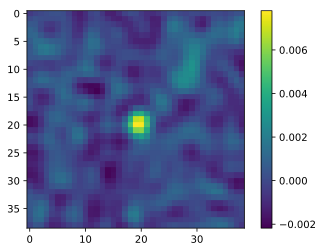

In [6]:
plt.imshow(np.asarray(np.concatenate([anal_bins.cuts[350][patch][0] for patch in patches])).mean(0))
plt.colorbar()

## Giulio's files: AKARI & Planck

In [7]:
giulio_fluxes = np.loadtxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_WISE4_SNR2_stacked_fluxes_soergel_allPointSourcesmask_allsrc.dat')
giulio_fluxes_corr = np.loadtxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_WISE4_SNR2_stacked_fluxes_soergel_GNILC-CIB_allPointSourcesmask_allsrc.dat')

## $1 < z < 2.15$

In [8]:
planck_bin1 = np.c_[giulio_fluxes[:-1,0], giulio_fluxes[:-1,2], giulio_fluxes[:-1,6]]
planck_corr_bin1 = np.c_[giulio_fluxes_corr[:,0], giulio_fluxes_corr[:,2], giulio_fluxes_corr[:,6]]

PLANCK_bin1        = planck_bin1.copy()
PLANCK_bin1[6:,1] -= planck_corr_bin1[:,1]
PLANCK_bin1[6:,2]  = np.sqrt(PLANCK_bin1[6:,2]**2 + planck_corr_bin1[:,2]**2)

akari_bin1 = np.c_[giulio_fluxes[-1,0], giulio_fluxes[-1,2], giulio_fluxes[-1,6]]


100 3.60580902598 0.896317358584
160 4.29766619972 1.91817606303
250 11.8753708398 1.80611928915
350 8.97344628885 1.79618126686
500 6.23808024413 1.30278827586


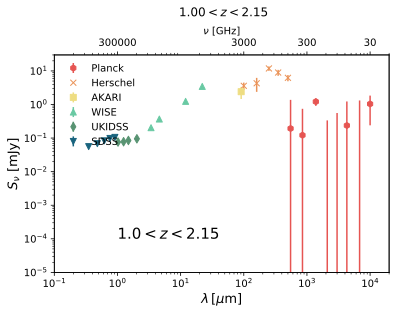

In [12]:
qso_cat_bins.PlotFromAnal(0,herschel=anal_bins, akari=akari_bin1, planck=PLANCK_bin1)
plt.text(1, 1e-4, r'$1.0 < z < 2.15$', fontsize=15)
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_1_z_2.15_wPACS_W4_SNR2_NEW.pdf', bboxes_inches='tight')

In [13]:
qso_cat_bins.WriteToFileFromAnal(0, herschel=anal_bins, planck=PLANCK_bin1, akari=akari_bin1, filename='SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_0_NEW')

100 3.41743072331
160 4.55072078618
250 11.6582067262
350 8.8636830535
500 5.9894896714


## $2.15 < z < 2.5$

In [14]:
planck_bin2 = np.c_[giulio_fluxes[:-1,0], giulio_fluxes[:-1,3], giulio_fluxes[:-1,7]]
planck_corr_bin2 = np.c_[giulio_fluxes_corr[:,0], giulio_fluxes_corr[:,3], giulio_fluxes_corr[:,7]]

PLANCK_bin2        = planck_bin2.copy()
PLANCK_bin2[6:,1] -= planck_corr_bin2[:,1]
PLANCK_bin2[6:,2]  = np.sqrt(PLANCK_bin2[6:,2]**2 + planck_corr_bin2[:,2]**2)

akari_bin2 = np.c_[giulio_fluxes[-1,0], giulio_fluxes[-1,3], giulio_fluxes[-1,7]]


100 1.73952063785 0.701256934334
160 4.16786979937 1.26738168642
250 8.63308461027 1.12363742813
350 8.36229786733 1.14480266571
500 5.25140404251 1.26309478807


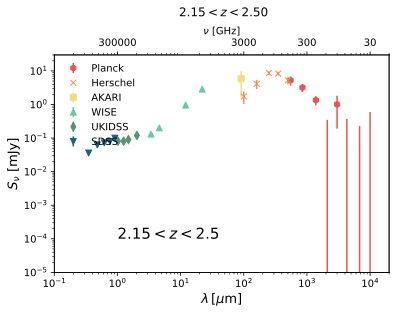

In [15]:
qso_cat_bins.PlotFromAnal(1,herschel=anal_bins, akari=akari_bin2, planck=PLANCK_bin2)
plt.text(1, 1e-4, r'$2.15 < z < 2.5$', fontsize=15)
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_2.15_z_2.5_wPACS_W4_SNR2_NEW.pdf', bboxes_inches='tight')

In [11]:
print qso_cat_bins.meanw4
print qso_cat_bins.meanw4_noKM

{0: 2.65957097595718, 1: 1.8291123966916922, 2: 1.9254504072720968}
{0: 3.4596696665334847, 1: 2.8762252374185575, 2: 2.9657009463843718}


In [16]:
qso_cat_bins.WriteToFileFromAnal(1, herschel=anal_bins, planck=PLANCK_bin2, akari=akari_bin2, filename='SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_1_NEW')

100 1.64148384315
160 4.06392863674
250 8.50579959733
350 8.23798634948
500 5.21742998399


## $2.5 < z < 5$

In [17]:
planck_bin3 = np.c_[giulio_fluxes[:-1,0], giulio_fluxes[:-1,4], giulio_fluxes[:-1,8]]
planck_corr_bin3 = np.c_[giulio_fluxes_corr[:,0], giulio_fluxes_corr[:,4], giulio_fluxes_corr[:,8]]

PLANCK_bin3        = planck_bin3.copy()
PLANCK_bin3[6:,1] -= planck_corr_bin3[:,1]
PLANCK_bin3[6:,2]  = np.sqrt(PLANCK_bin3[6:,2]**2 + planck_corr_bin3[:,2]**2)

akari_bin3 = np.c_[giulio_fluxes[-1,0], giulio_fluxes[-1,4], giulio_fluxes[-1,8]]


100 2.82872327643 0.699238990868
160 4.68023798105 1.454566257
250 8.9870067872 1.27128531036
350 7.86664135582 1.18004999503
500 7.45557846773 0.946031228215


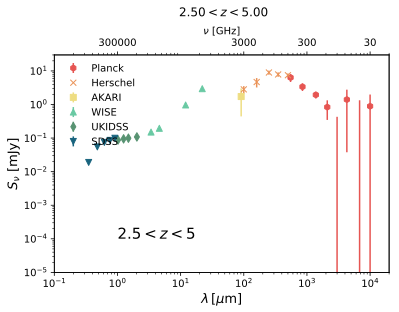

In [18]:
qso_cat_bins.PlotFromAnal(2,herschel=anal_bins, akari=akari_bin3, planck=PLANCK_bin3)
plt.text(1, 1e-4, r'$2.5 < z < 5$', fontsize=15)
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_2.5_z_5_wPACS_W4_SNR2_NEW.pdf', bboxes_inches='tight')

In [19]:
qso_cat_bins.WriteToFileFromAnal(2, herschel=anal_bins, planck=PLANCK_bin3, akari=akari_bin3, filename='SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_NEW')

100 2.57914955137
160 4.40575163554
250 8.86767916849
350 7.68425954359
500 8.24203136074


In [29]:
print qso_cat_bins.meanw2
print qso_cat_bins.errw2_limits


{0: 0.3760145881733774, 1: 0.1725473515270173, 2: 0.18557706671281485}
{0: [(0.003361436493763548, 0.003361436493763548)], 1: [(0.0019509834494670247, 0.0019509834494670247)], 2: [(0.0021297607445749777, 0.0021297607445749777)]}


(1e-05, 30)

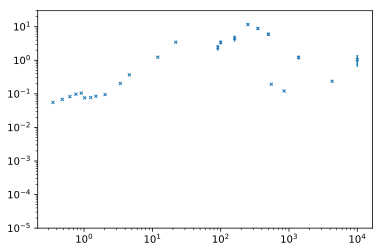

In [24]:
a = np.loadtxt('SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_zbin_1.0_2.15.dat')
b = np.loadtxt('SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_0_NEW_zbin_1.0_2.15.dat')
plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='x', ms=3)
# plt.errorbar(b[:,0]+10,b[:,1],yerr=[b[:,2],b[:,3]], fmt='x', ms=3)
plt.xscale('log');
plt.yscale('log');
plt.ylim([1e-5,30])

In [41]:
print qso_cat_bins.errw1_limits[0]
print qso_cat_bins.errw2_limits[0]
print qso_cat_bins.errw3_limits[0]
print qso_cat_bins.errw4_limits[0]

[(0.096704549800788603, 0.096704549800788603)]
[(0.18900983608934577, 0.18900983608934577)]
[(0.61045304817348922, 0.61045304817348922)]
[(1.3066524696555977, 1.3066524696555977)]


In [48]:
print qso_cat_bins.errw1_limits[0]
print qso_cat_bins.errw2_limits[0]
print qso_cat_bins.errw3_limits[0]
print qso_cat_bins.errw4_limits[0]

[(3.8932841863015266e-05, 0.0)]
[(2.0633492047894553e-05, 0.0)]
[(0.02609175676007025, 0.0)]
[(0.0, 0.0)]


In [54]:
print qso_cat_bins.errw1_limits[0]
print qso_cat_bins.errw2_limits[0]
print qso_cat_bins.errw3_limits[0]
print qso_cat_bins.errw4_limits[0]

[(0.00085970638737107208, 0.00085970638737107208)]
[(0.0016803031883888141, 0.0016803031883888141)]
[(0.0054269461549223798, 0.0054269461549223798)]
[(0.011616180175091853, 0.011616180175091853)]


In [25]:
errs = {}
for l in anal_bins.lambdas:
    errs[l] = np.asarray([anal_bins.GetTotBootstrapErrsFit2D(l,0, nsim=100) for i in xrange(100)]) 

64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0
64.0


KeyboardInterrupt: 

In [ ]:
for l in anal_bins.lambdas:
    print l, np.mean(errs[l]), np.std(errs[l])

In [161]:
for l in anal_bins.lambdas:
    print l, np.mean(errs[l]), np.std(errs[l])

100 2.25030139039 10.9551913024
160 5.67886409299 28.1980548467
250 6.95515809946 50.8098168993
350 2.28038846757 4.32366894249
500 3.64985732004 9.35287204645


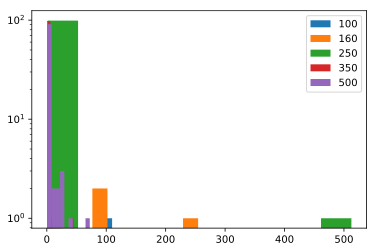

In [163]:
for l in anal_bins.lambdas:
    plt.hist(errs[l], label=str(l))
plt.legend()
plt.yscale('log')

## Save RA,DEC positions to file

In [44]:
for i in xrange(3):
    np.savetxt('SDSS_DR7_DR12_W4_SNR2_selected_'+str(qso_cat_bins.zbins[i][0])+'_'+str(qso_cat_bins.zbins[i][1])+'.dat', np.c_[qso_cat_bins.cat[i].RA,qso_cat_bins.cat[i].DEC], header='RA DEC')
                     

## Check w/ Giulio's plots

In [10]:
giulio_fluxes = np.loadtxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_WISE4_SNR2_stacked_fluxes_soergel_allPointSourcesmask_allsrc.dat')
# giulio_fluxes_corr = np.loadtxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_GNILC_CIB_stacked_fluxes_soergel_allPointSourcesmask_allsrc.dat')

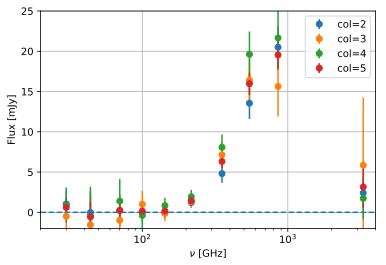

In [39]:
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,2], 2*giulio_fluxes[:,6], fmt='o', label='col=2')
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,3], 2*giulio_fluxes[:,7], fmt='o', label='col=3')
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,4], 2*giulio_fluxes[:,8], fmt='o', label='col=4')
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,5], 2*giulio_fluxes[:,9], fmt='o', label='col=5')
plt.xscale('log')
plt.axhline(ls='--')
plt.ylim([-2,25])
plt.xlim([20,4000])
plt.grid()
plt.legend()
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'Flux [mJy]')
plt.savefig('check_fluxes_w_Giulio.pdf')

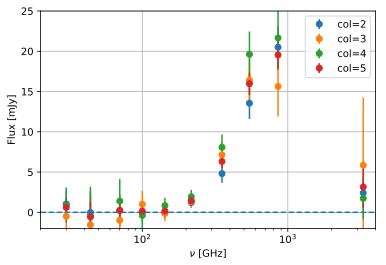

In [41]:
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,2], 2*giulio_fluxes[:,6], fmt='o', label='col=2')
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,3], 2*giulio_fluxes[:,7], fmt='o', label='col=3')
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,4], 2*giulio_fluxes[:,8], fmt='o', label='col=4')
plt.errorbar(giulio_fluxes[:,1], giulio_fluxes[:,5], 2*giulio_fluxes[:,9], fmt='o', label='col=5')
plt.xscale('log')
plt.axhline(ls='--')
plt.ylim([-2,25])
plt.xlim([20,4000])
plt.grid()
plt.legend()
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'Flux [mJy]')
plt.savefig('check_fluxes_w_Giulio_new.pdf')

In [104]:
qso_cat_bins.errw2_limits

{0: [(-0.00038452029344537841, 0.00040515378549327297)],
 1: [(-0.00022532172150960261, 0.0003830233154210605)],
 2: [(-7.2360457700482161e-05, 0.00037921337814497691)]}

<Container object of 3 artists>

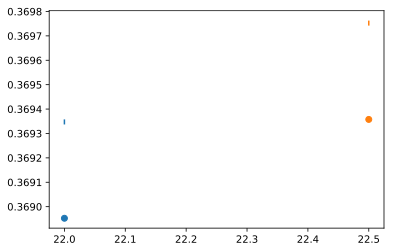

In [103]:
plt.errorbar(22, qso_cat_bins.meanw2[0], yerr=np.asarray(qso_cat_bins.errw2_limits[0]).T, fmt ='o')
plt.errorbar(22+0.5, qso_cat_bins.meanw2_noKM[0], yerr=np.asarray(qso_cat_bins.errw2_limits[0]).T, fmt ='o')

<Container object of 3 artists>

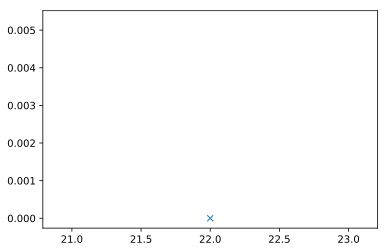

In [99]:
plt.errorbar(22, 0, yerr=np.asarray(qso_cat_bins.errw4_limits[0]).T, fmt ='x')

In [100]:
np.asarray(qso_cat_bins.errw4_limits[0]).T

array([[-0.00525446],
       [ 0.00525446]])

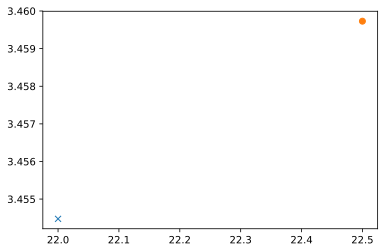

In [115]:
plt.plot(22, qso_cat_bins.meanw4[0], 'x')
plt.plot(22+0.5, qso_cat_bins.meanw4_noKM[0], 'o')

## Check mean/median z-bins for the full sample (for Joaquin)

In [164]:
qso_cat_bins_all = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins)


	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0


In [147]:
for i in xrange(len(qso_cat_bins_all.zbins)):
    print '%.2f < z < %.2f' %(qso_cat_bins_all.zbins[i][0],qso_cat_bins_all.zbins[i][1])
    print 'mean   = %.2f' %np.mean(qso_cat_bins_all.cat[i].Z)
    print 'median = %.2f' %np.median(qso_cat_bins_all.cat[i].Z)
    print ''

1.00 < z < 2.15
mean   = 1.60
median = 1.61

2.15 < z < 2.50
mean   = 2.32
median = 2.32

2.50 < z < 5.00
mean   = 2.95
median = 2.85



In [126]:
qso_cat_bins_all.zbins[0]

(1.0, 2.15)

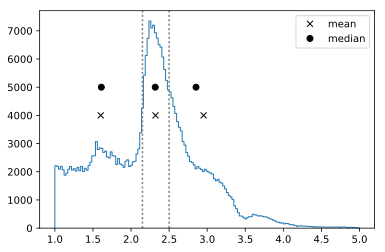

In [148]:
hist(np.concatenate([qso_cat_bins_all.cat[i].Z for i in xrange(3)]), 'knuth', histtype='step')
plt.axvline(2.15, color='grey', ls=':')
plt.axvline(2.5, color='grey', ls=':')
for i in xrange(len(qso_cat_bins_all.zbins)):
    if i == 0:
        lab_mean = 'mean' 
        lab_meed = 'median' 
    else:
        lab_mean = None 
        lab_meed = None         
    plt.plot(np.mean(qso_cat_bins_all.cat[i].Z), 4000, 'kx', label=lab_mean)
    plt.plot(np.median(qso_cat_bins_all.cat[i].Z), 5000, 'ko', label=lab_meed)
#     plt.errorbar([np.median(qso_cat_bins_all.cat[i].Z)], [5000], xerr=np.asarray([np.median(qso_cat_bins_all.cat[i].Z)-np.percentile(qso_cat_bins_all.cat[i].Z,16), np.percentile(qso_cat_bins_all.cat[i].Z,84) - np.median(qso_cat_bins_all.cat[i].Z)]).T,)
plt.legend()
plt.savefig('mean_median_dNdz_QSO.pdf')

In [138]:
np.percentile(qso_cat_bins_all.cat[0].Z,84)

1.9874989013671875

In [33]:
anal_bins.GetTotBootstrapErrsFit2D(250,0, nsim=100, remove_max=0, nboot=1)

125


1.7145036430237806

In [32]:
anal_bins.GetTotBootstrapErrsFit2D(250,0, nsim=100, remove_max=0, nboot=2)

62


1.8995313053559031